# AVIRIS Fixed Shape Experiment

This notebook implements the AVIRIS Fixed Shape Experiment, which extends the original AVIRIS compression model to:
1. Record important shapes from Stage 1 (initial, lowest condition number, lowest test MSE)
2. Run Stage 2 with fixed shapes from Stage 1, optimizing only the decoder
3. Compare performance of different fixed shapes

# AVIRIS Fixed Shape Experiment - Example Notebook

This notebook demonstrates how to use the streamlined AVIRIS Fixed Shape Experiment code.

## Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime
from tqdm.notebook import tqdm

# Import our streamlined modules
from aviris_fixed_shape_notebook import *
from aviris_utils import *

In [3]:
# Set random seed for reproducibility
set_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Data Loading

# Configure data parameters
tile_size = 100  # Size of image tiles
use_cache = 'cache_simple'  # Cache directory
folder = 'all'  # Which folder to use (or 'all')

# Load data
tiles = process_and_load_data(
    tile_size=tile_size,
    use_cache=use_cache,
    folder=folder
)

# Display basic information about the data
print(f"Loaded {tiles.shape[0]} tiles with shape {tiles.shape[1:]} (C×H×W)")

## Experiment Configuration

# Define experiment parameters
output_dir = create_timestamp_dir("aviris_experiment")
print(f"Results will be saved to: {output_dir}")

# Model parameters
latent_dim = 11
model_type = 'cnn'  # Use 'awan' if available
use_fsf = True
shape2filter_path = "outputs_three_stage_20250322_145925/stageA/shape2spec_stageA.pt"
filter2shape_path = "outputs_three_stage_20250322_145925/stageC/spec2shape_stageC.pt"
filter_scale_factor = 50.0

# Training parameters
stage1_epochs = 10  # Use more epochs (e.g., 50) for better results
stage2_epochs = 20  # Use more epochs (e.g., 100) for better results
batch_size = 8
encoder_lr = 1e-3
decoder_lr = 5e-4
min_snr = 10
max_snr = 40

Random seed set to 42
Using device: cuda
Using existing cache: cache_simple/tiles_100.pt
Loading cached tiles from: cache_simple/tiles_100.pt
Loaded 4771 tiles with shape torch.Size([100, 100, 100]) (C×H×W)
Loaded 4771 tiles with shape torch.Size([100, 100, 100]) (C×H×W)
Results will be saved to: aviris_experiment_20250403_030537


Using device: cuda
Random seed set to 42
Dataset split: 3817 training samples, 954 test samples
Filter2Shape2Filter integration enabled.
Using filter scale factor: 50.0

=== Stage 1: Learning filter shape and decoder ===
FSF pipeline initialized in LinearEncoder
Model initialized with:
- 100 input channels
- 11 latent dimensions
- cnn decoder
- FSF pipeline: Enabled
Recorded initial shape with condition number: 189.4875


Stage 1 Epoch 1/10:   0%|          | 0/478 [00:00<?, ?it/s]

/home/lachlan/miniconda3/envs/iccp/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1725570624180/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/lachlan/miniconda3/envs/iccp/lib/python3.9/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1725570624180/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


New lowest condition number: 234.4383
New lowest test MSE: 0.001689
Epoch 1/10, Train Loss: 0.004578, Test Loss: 0.001689
Saved new best model with test loss: 0.001689


Stage 1 Epoch 2/10:   0%|          | 0/478 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.001571, Test Loss: 0.001951


Stage 1 Epoch 3/10:   0%|          | 0/478 [00:00<?, ?it/s]

New lowest test MSE: 0.000519
Epoch 3/10, Train Loss: 0.001275, Test Loss: 0.000519
Saved new best model with test loss: 0.000519


Stage 1 Epoch 4/10:   0%|          | 0/478 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.001015, Test Loss: 0.000600


Stage 1 Epoch 5/10:   0%|          | 0/478 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.000943, Test Loss: 0.001048


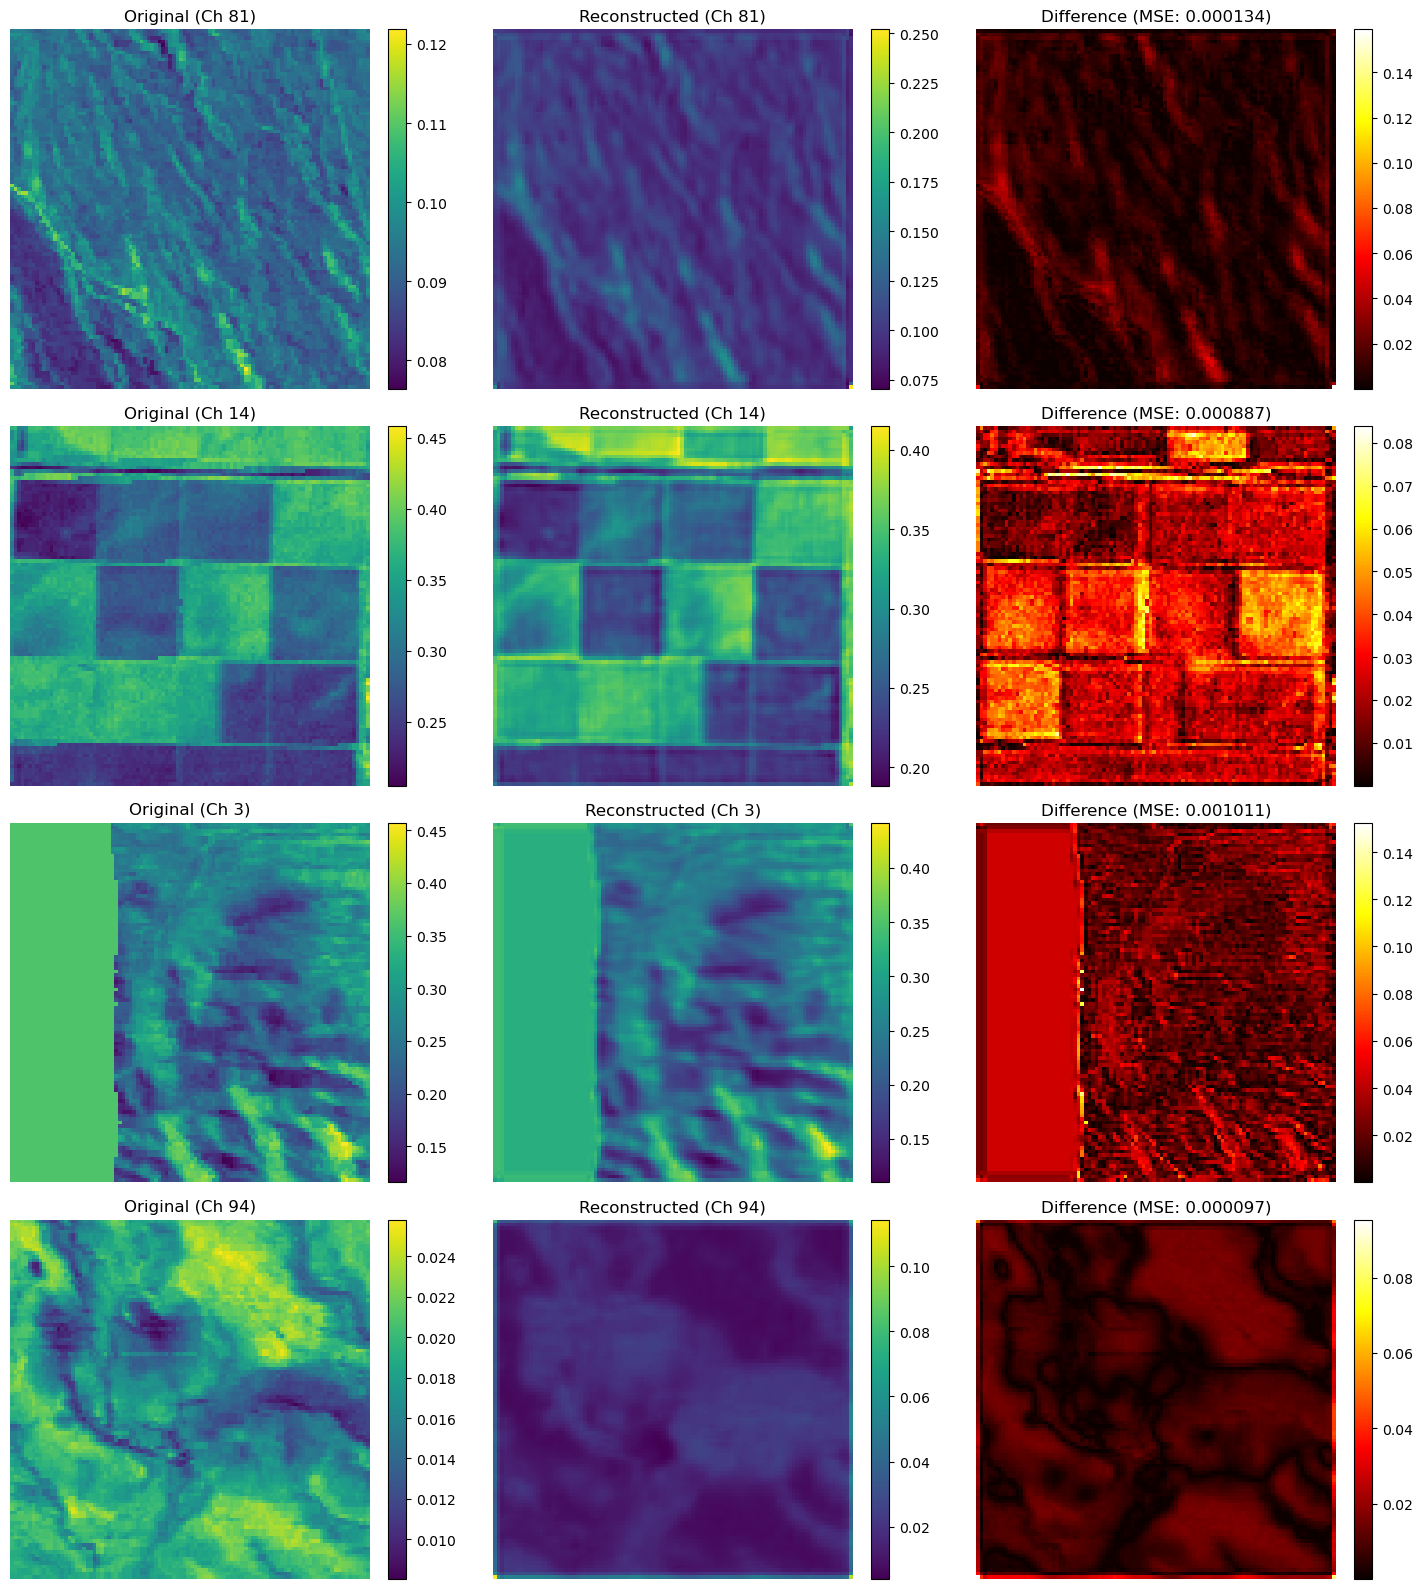

Stage 1 Epoch 6/10:   0%|          | 0/478 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.000909, Test Loss: 0.001223


Stage 1 Epoch 7/10:   0%|          | 0/478 [00:00<?, ?it/s]

New lowest test MSE: 0.000492
Epoch 7/10, Train Loss: 0.000756, Test Loss: 0.000492
Saved new best model with test loss: 0.000492


Stage 1 Epoch 8/10:   0%|          | 0/478 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.000655, Test Loss: 0.001026


Stage 1 Epoch 9/10:   0%|          | 0/478 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.000826, Test Loss: 0.000580


Stage 1 Epoch 10/10:   0%|          | 0/478 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.000675, Test Loss: 0.000565


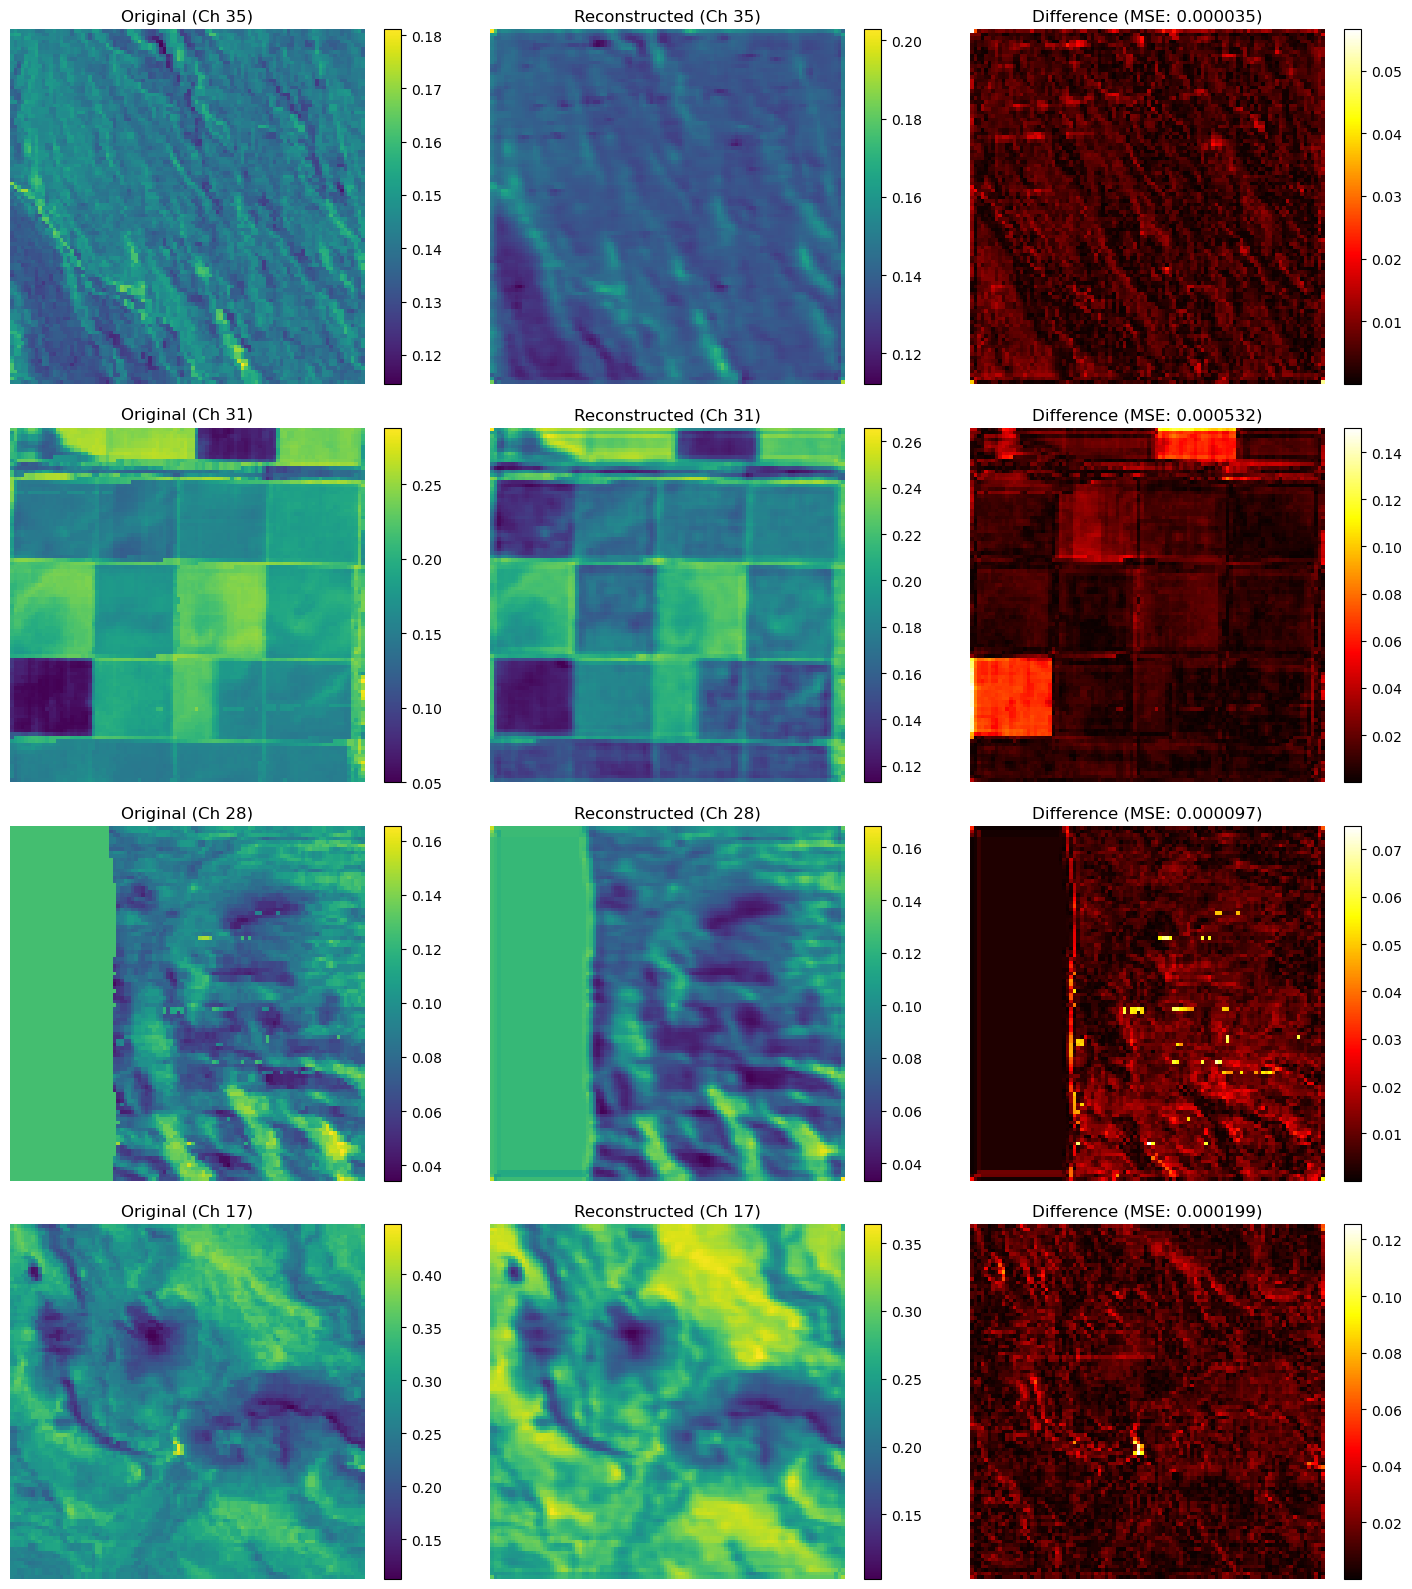

Recorded final shape with condition number: 237.3361


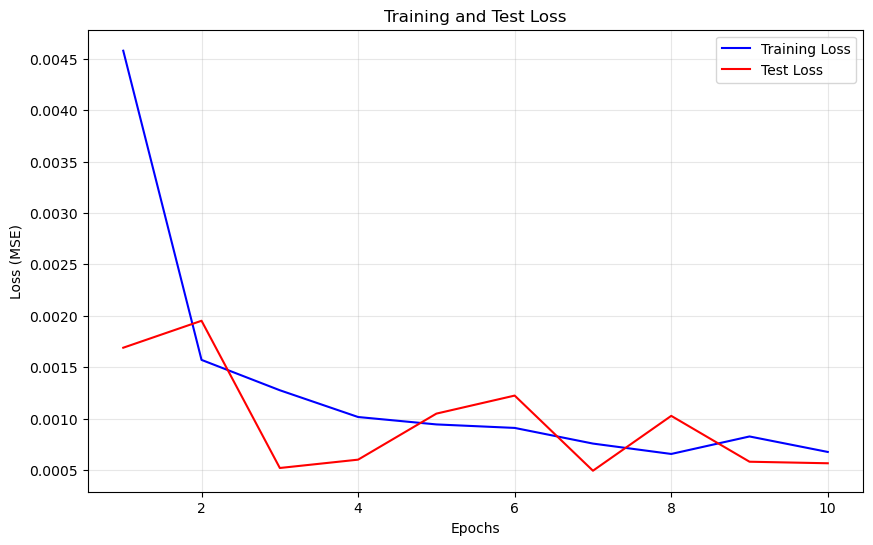

In [4]:
## Option 1: Run Stage 1 Only

# Run stage 1 to learn filter shapes
stage1_results = train_stage1(
    tiles=tiles,
    latent_dim=latent_dim,
    model_type=model_type,
    use_fsf=use_fsf,
    shape2filter_path=shape2filter_path,
    filter2shape_path=filter2shape_path,
    filter_scale_factor=filter_scale_factor,
    epochs=stage1_epochs,
    batch_size=batch_size,
    encoder_lr=encoder_lr,
    decoder_lr=decoder_lr,
    min_snr=min_snr,
    max_snr=max_snr,
    output_dir=os.path.join(output_dir, "stage1_only")
)

# Get results from stage 1
model = stage1_results['model']
recorded_shapes = stage1_results['recorded_shapes']
recorded_metrics = stage1_results['recorded_metrics']
train_loader = stage1_results['train_loader']
test_loader = stage1_results['test_loader']

initial shape:
  - Condition Number: 189.4875
  - Test MSE: inf
lowest_condition_number shape:
  - Condition Number: 234.4383
  - Test MSE: 0.001689
lowest_test_mse shape:
  - Condition Number: 235.8855
  - Test MSE: 0.000492
final shape:
  - Condition Number: 237.3361
  - Test MSE: 0.000565


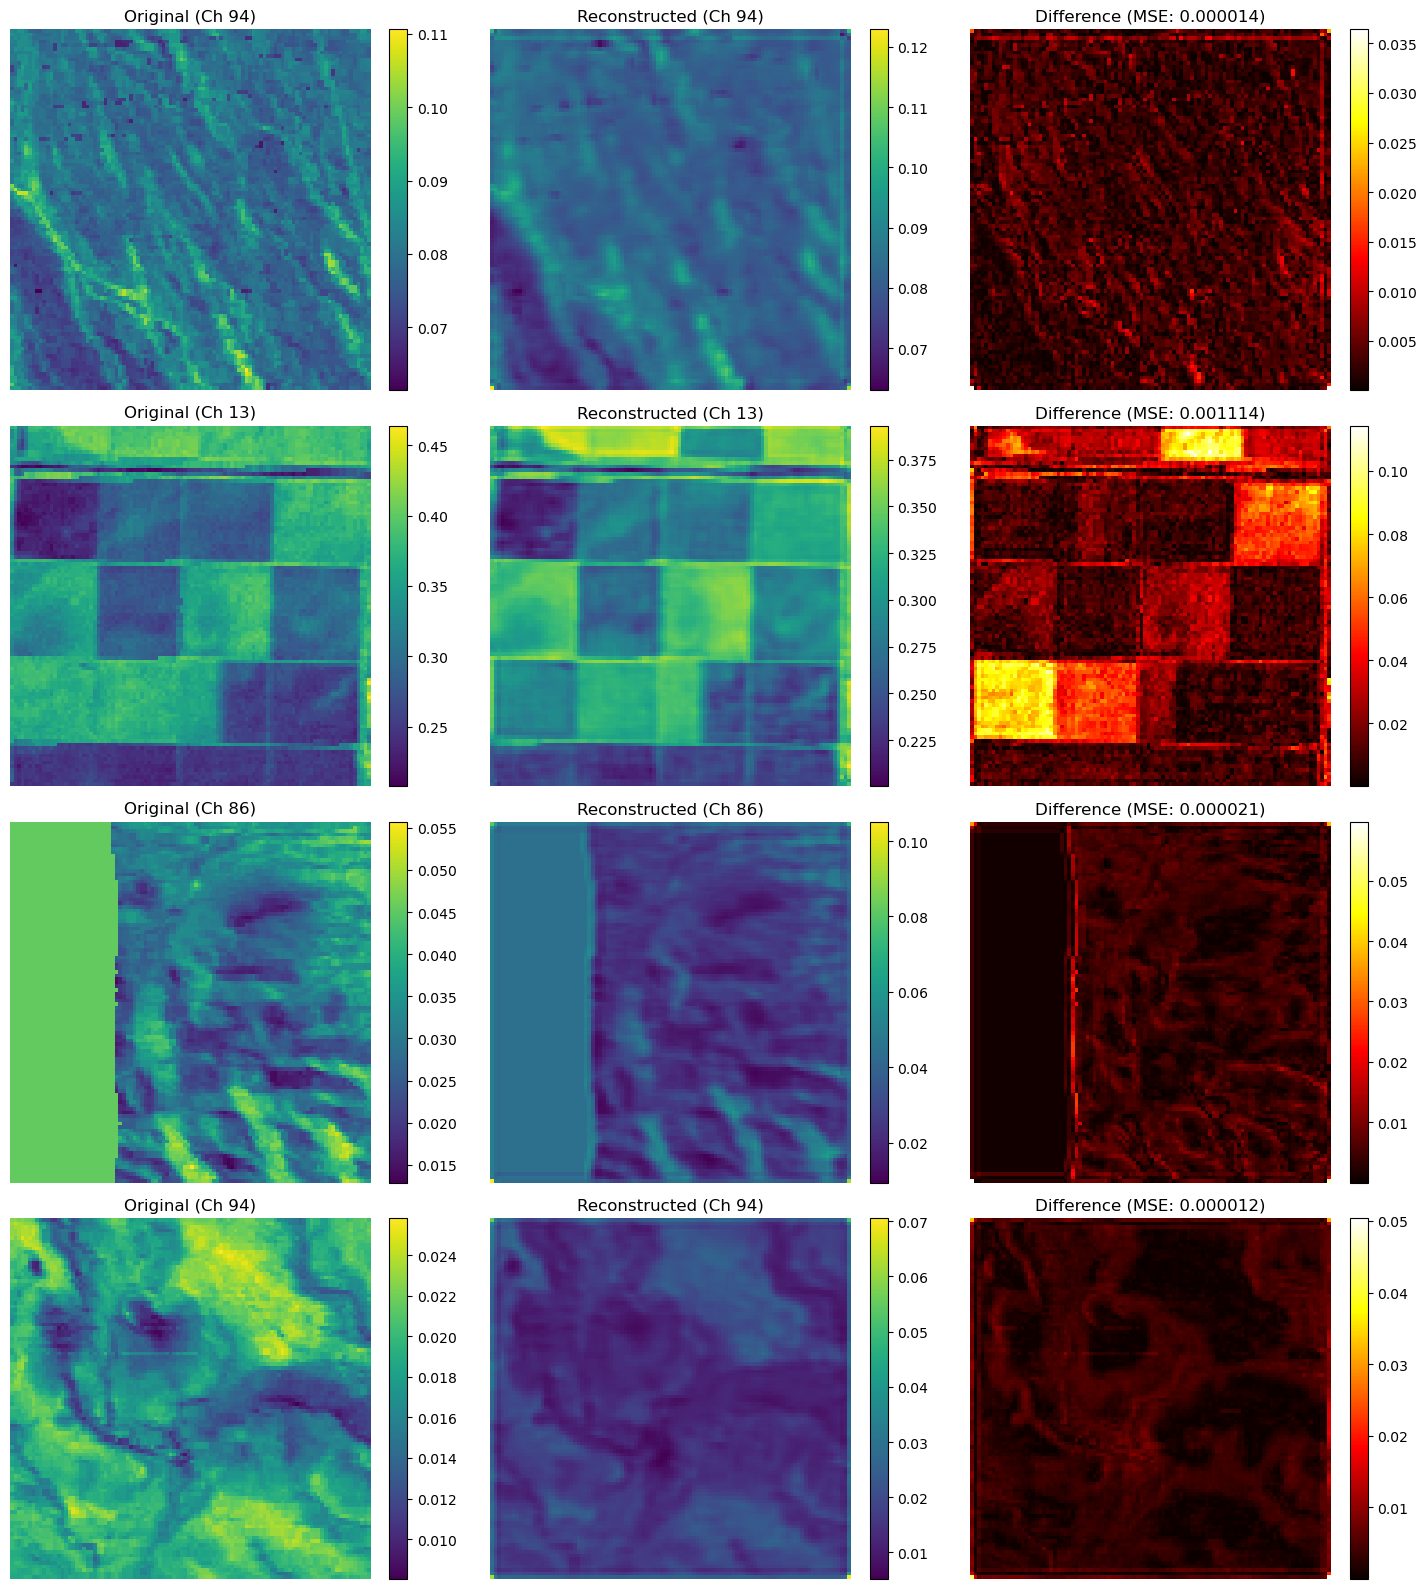

In [5]:
# Visualize the learned filter shapes
for shape_name, shape in recorded_shapes.items():
    print(f"{shape_name} shape:")
    print(f"  - Condition Number: {recorded_metrics[shape_name]['condition_number']:.4f}")
    print(f"  - Test MSE: {recorded_metrics[shape_name]['test_mse']:.6f}")

# Visualize some reconstructions
visualize_reconstruction(model, test_loader, device)

Fixed shape encoder initialized with filter of shape torch.Size([11, 100])

Training Stage 2 model with lowest_test_mse shape...


Stage 2 [lowest_test_mse] Epoch 1/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 1/20, Train Loss: 0.009165, Test Loss: 0.005767
Saved new best model with test loss: 0.005767


Stage 2 [lowest_test_mse] Epoch 2/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 2/20, Train Loss: 0.005041, Test Loss: 0.005147
Saved new best model with test loss: 0.005147


Stage 2 [lowest_test_mse] Epoch 3/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 3/20, Train Loss: 0.003685, Test Loss: 0.002789
Saved new best model with test loss: 0.002789


Stage 2 [lowest_test_mse] Epoch 4/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 4/20, Train Loss: 0.003136, Test Loss: 0.005179


Stage 2 [lowest_test_mse] Epoch 5/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 5/20, Train Loss: 0.002943, Test Loss: 0.002724
Saved new best model with test loss: 0.002724


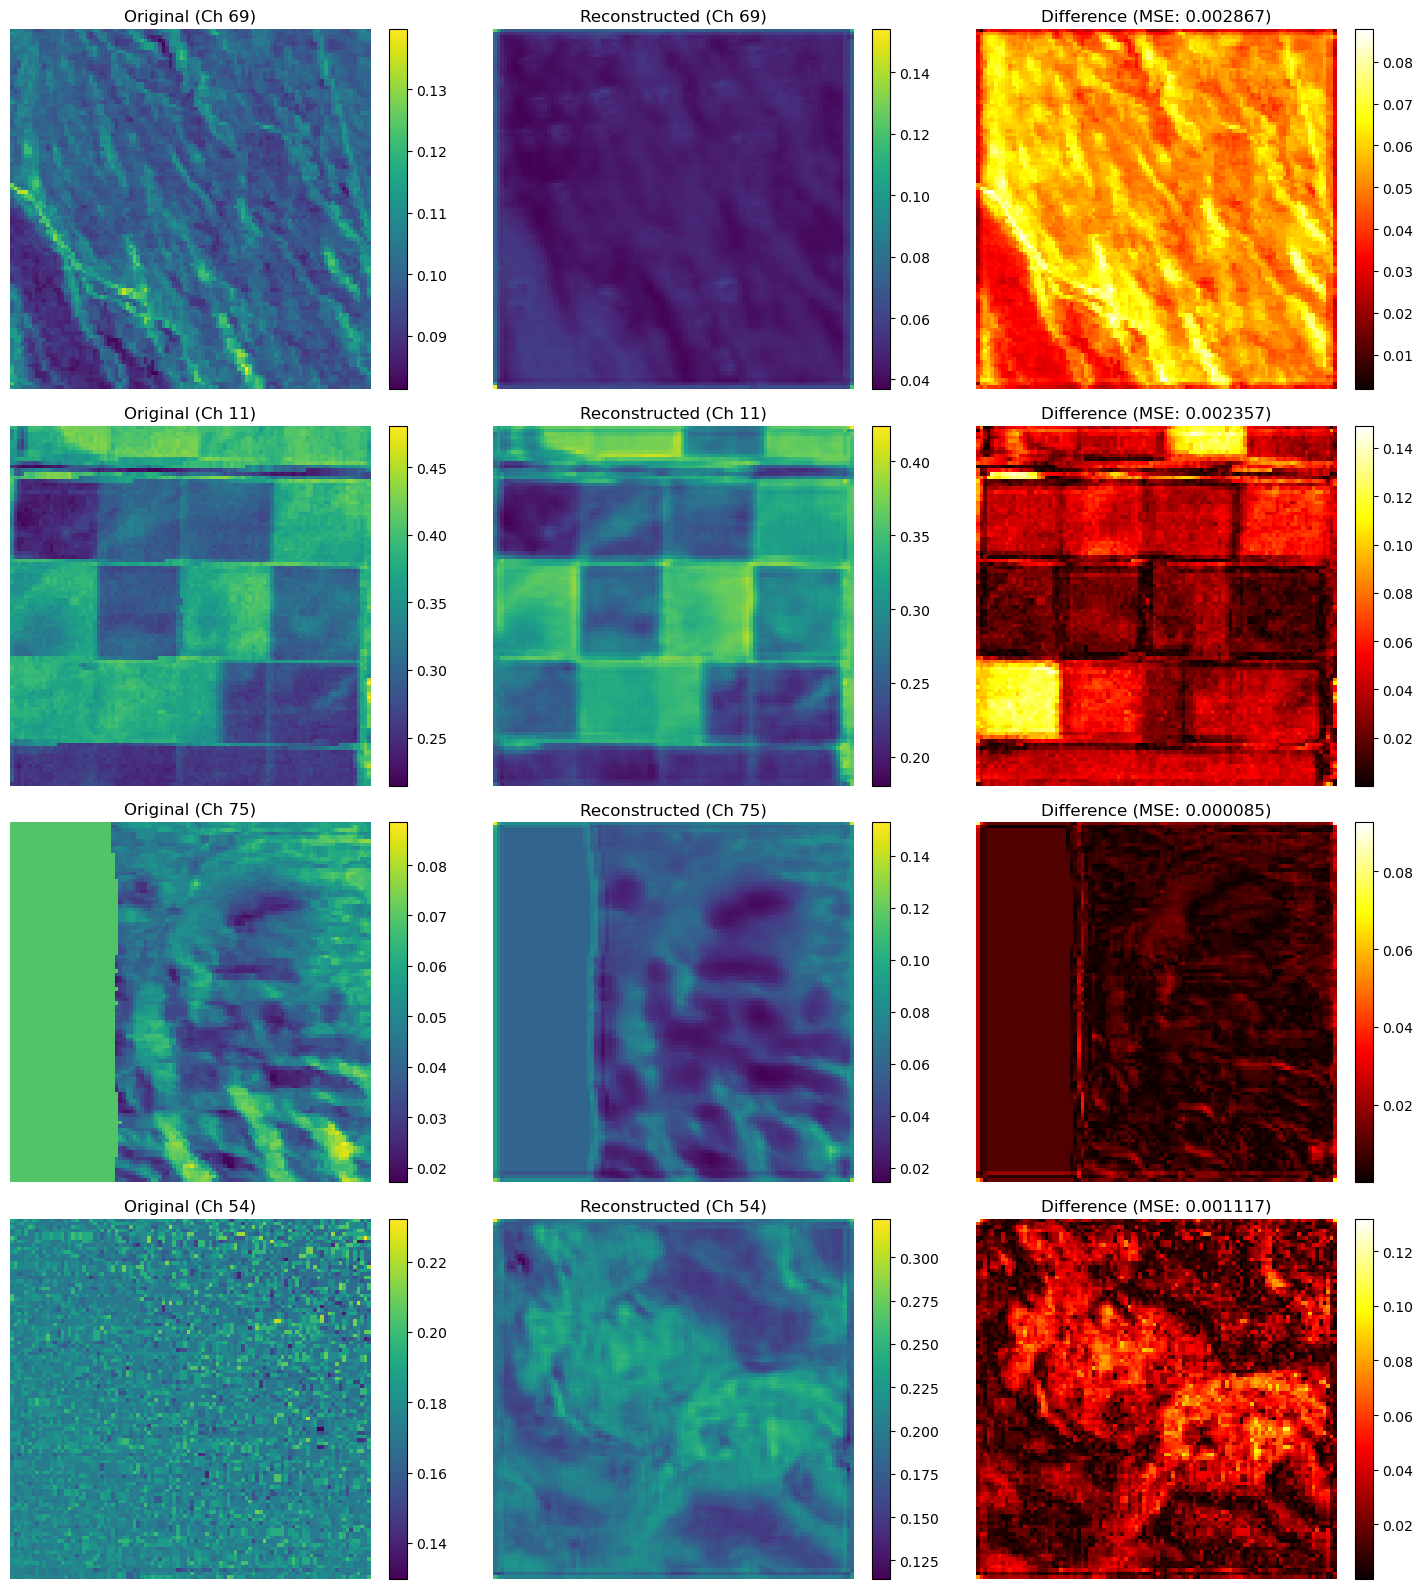

Stage 2 [lowest_test_mse] Epoch 6/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 6/20, Train Loss: 0.002986, Test Loss: 0.019125


Stage 2 [lowest_test_mse] Epoch 7/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 7/20, Train Loss: 0.003299, Test Loss: 0.016284


Stage 2 [lowest_test_mse] Epoch 8/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 8/20, Train Loss: 0.002771, Test Loss: 0.003077


Stage 2 [lowest_test_mse] Epoch 9/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 9/20, Train Loss: 0.002563, Test Loss: 0.002396
Saved new best model with test loss: 0.002396


Stage 2 [lowest_test_mse] Epoch 10/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 10/20, Train Loss: 0.002475, Test Loss: 0.003440


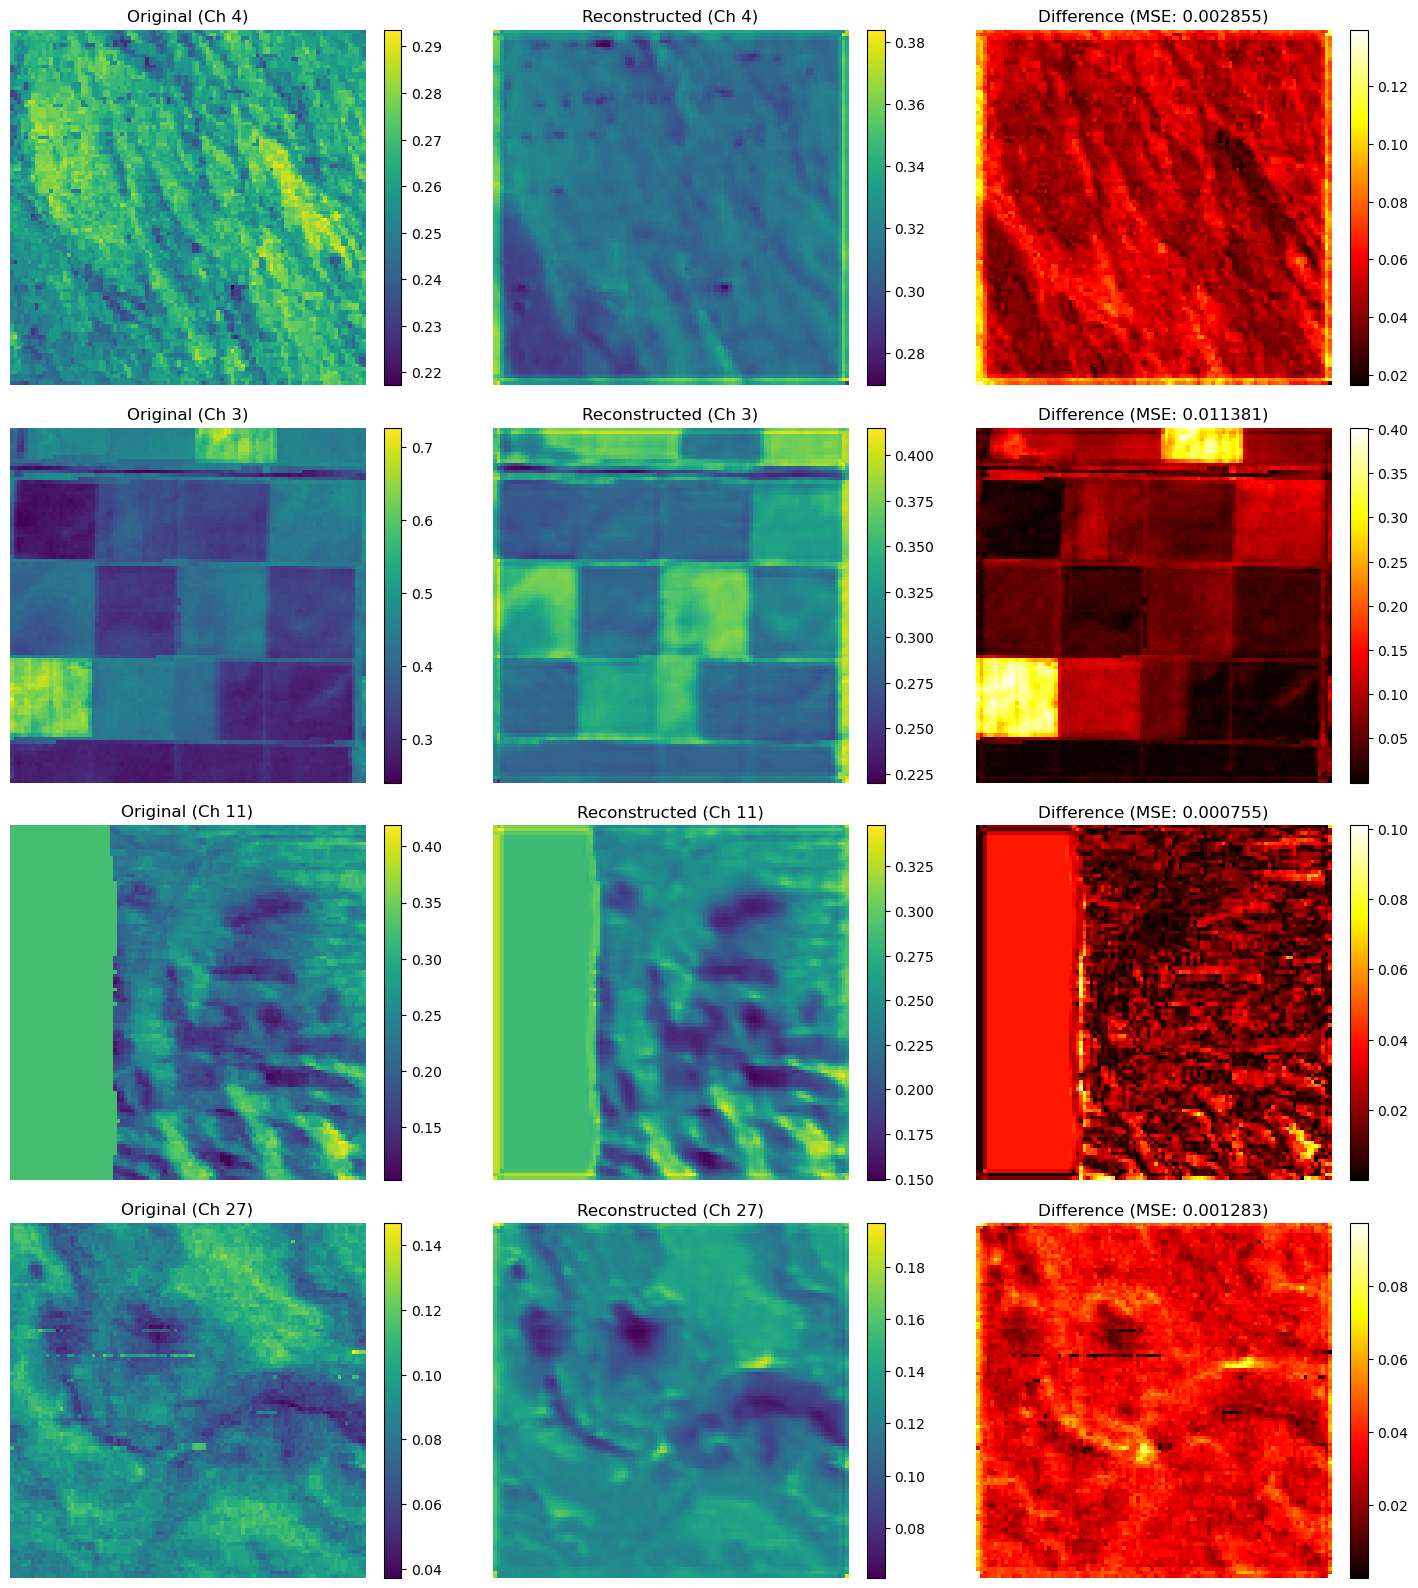

Stage 2 [lowest_test_mse] Epoch 11/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 11/20, Train Loss: 0.002521, Test Loss: 0.002930


Stage 2 [lowest_test_mse] Epoch 12/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 12/20, Train Loss: 0.002349, Test Loss: 0.002304
Saved new best model with test loss: 0.002304


Stage 2 [lowest_test_mse] Epoch 13/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 13/20, Train Loss: 0.002314, Test Loss: 0.002514


Stage 2 [lowest_test_mse] Epoch 14/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 14/20, Train Loss: 0.002581, Test Loss: 0.002443


Stage 2 [lowest_test_mse] Epoch 15/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 15/20, Train Loss: 0.002220, Test Loss: 0.002611


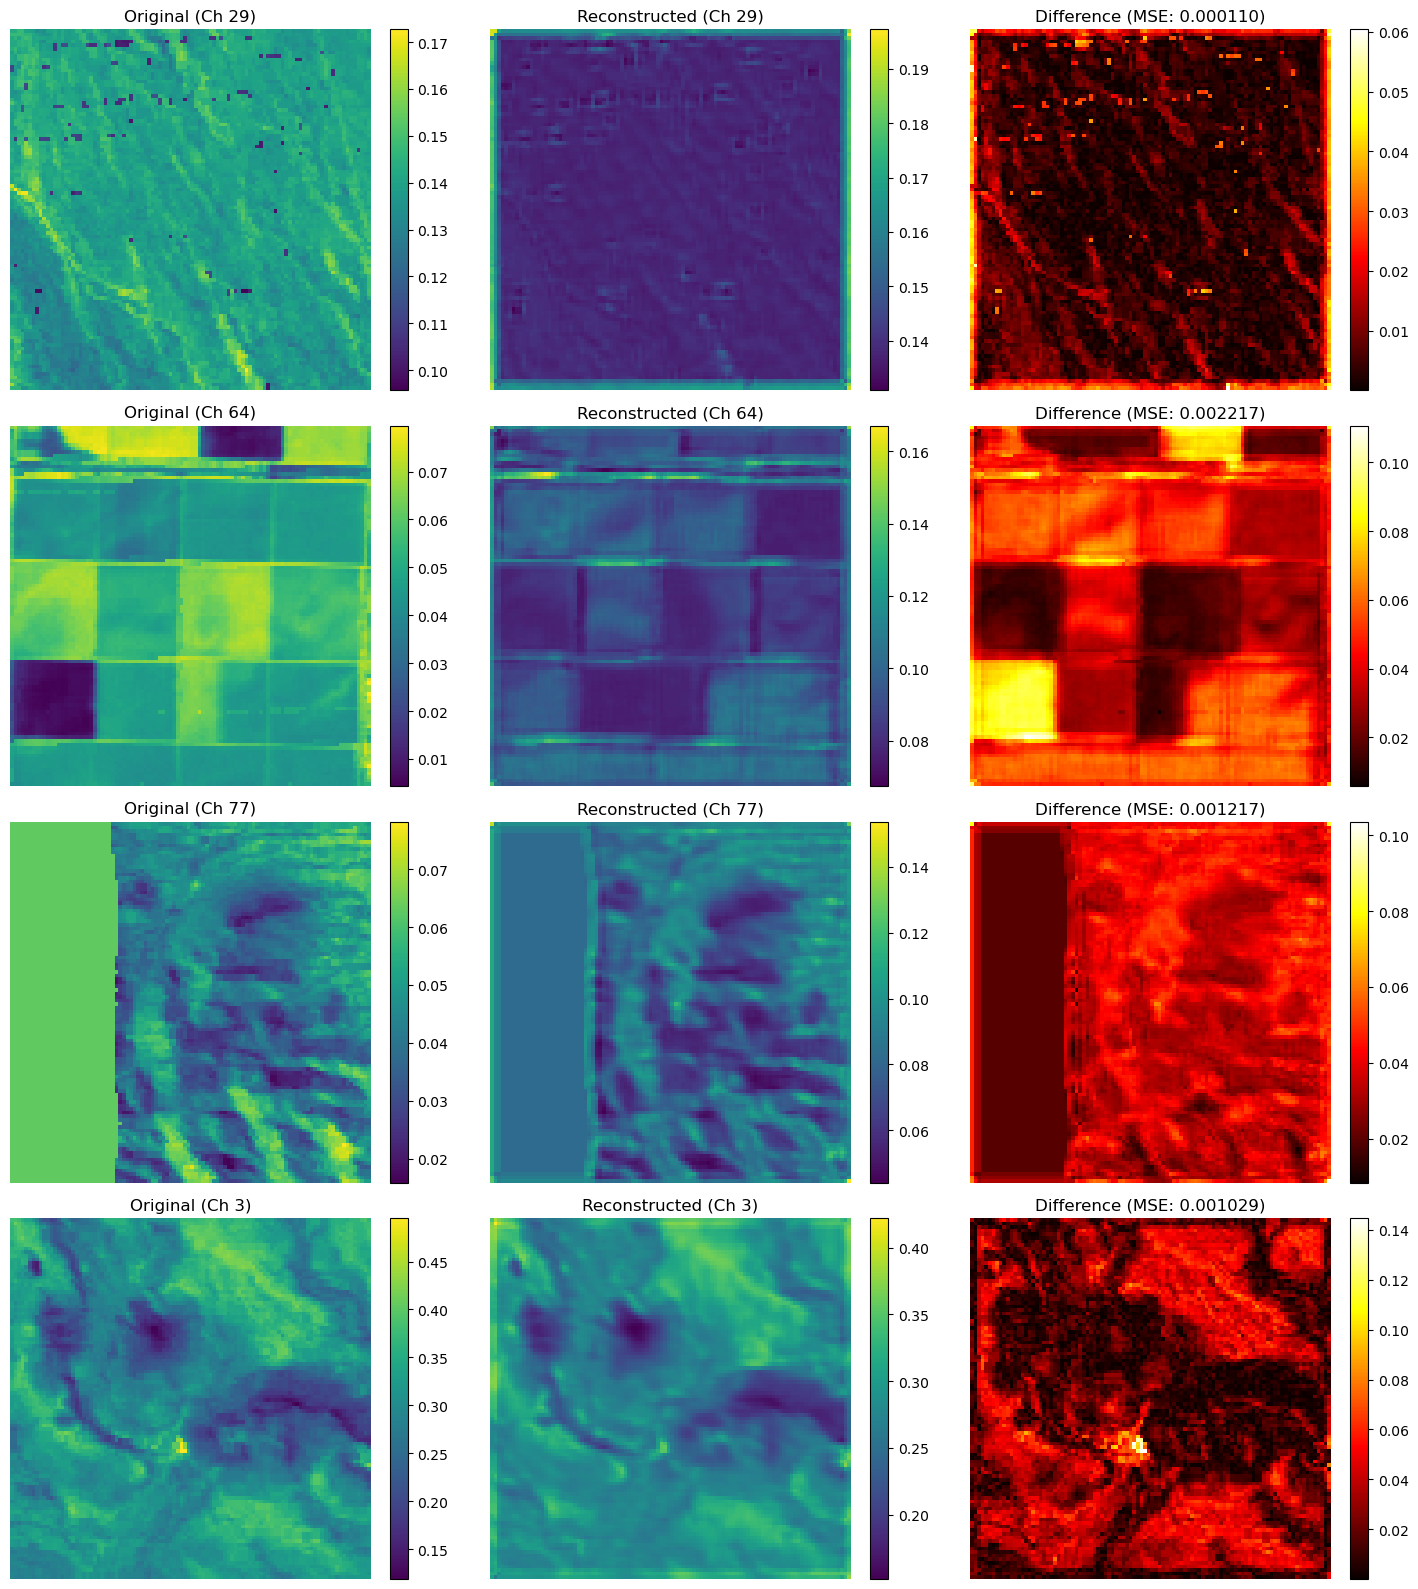

Stage 2 [lowest_test_mse] Epoch 16/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 16/20, Train Loss: 0.002206, Test Loss: 0.005177


Stage 2 [lowest_test_mse] Epoch 17/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 17/20, Train Loss: 0.002241, Test Loss: 0.002951


Stage 2 [lowest_test_mse] Epoch 18/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 18/20, Train Loss: 0.002204, Test Loss: 0.002131
Saved new best model with test loss: 0.002131


Stage 2 [lowest_test_mse] Epoch 19/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 19/20, Train Loss: 0.002175, Test Loss: 0.004372


Stage 2 [lowest_test_mse] Epoch 20/20:   0%|          | 0/478 [00:00<?, ?it/s]

[lowest_test_mse] Epoch 20/20, Train Loss: 0.002342, Test Loss: 0.003485


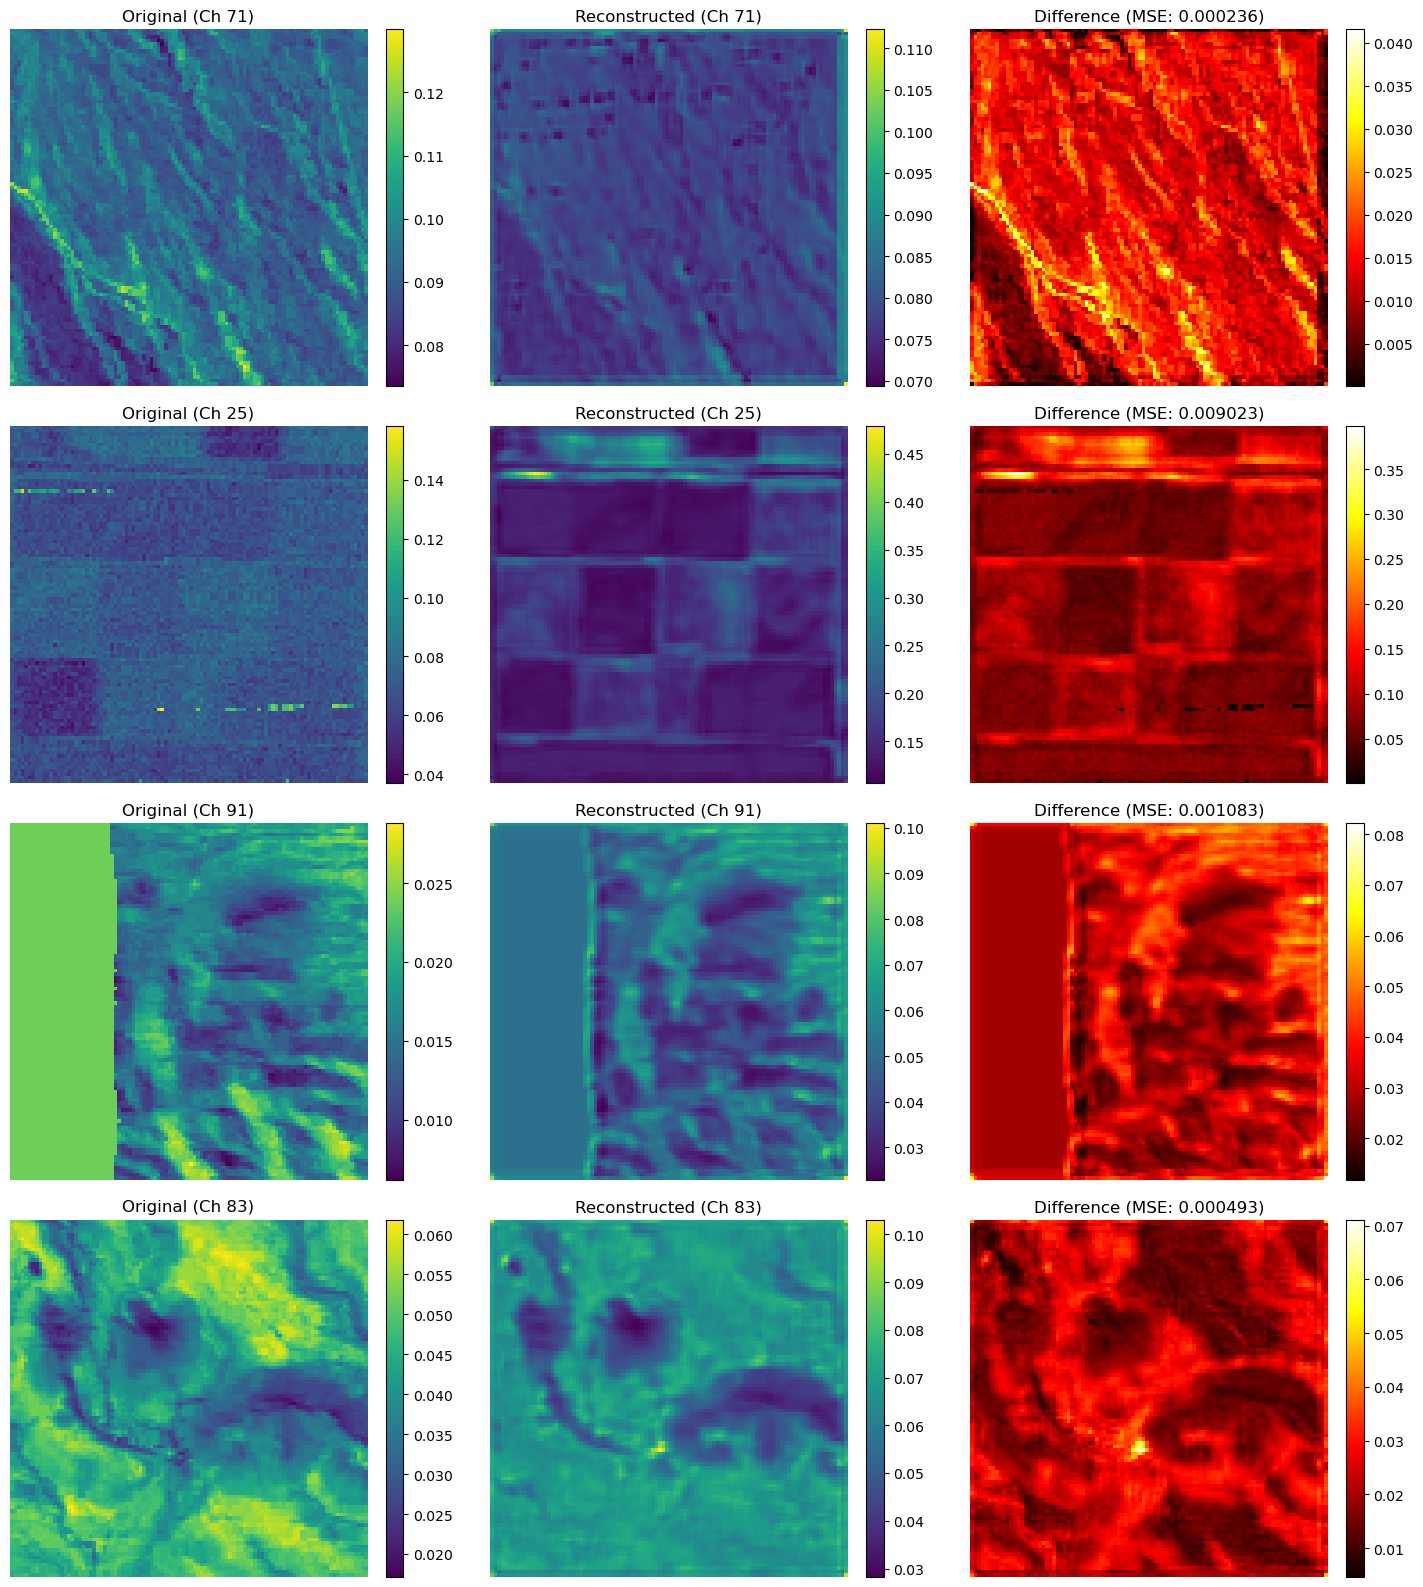

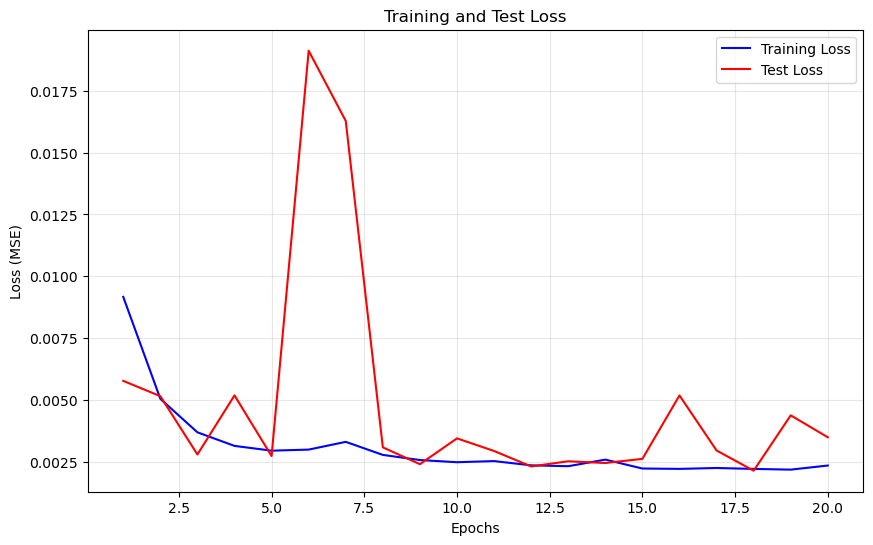

Stage 2 training for lowest_test_mse shape complete!


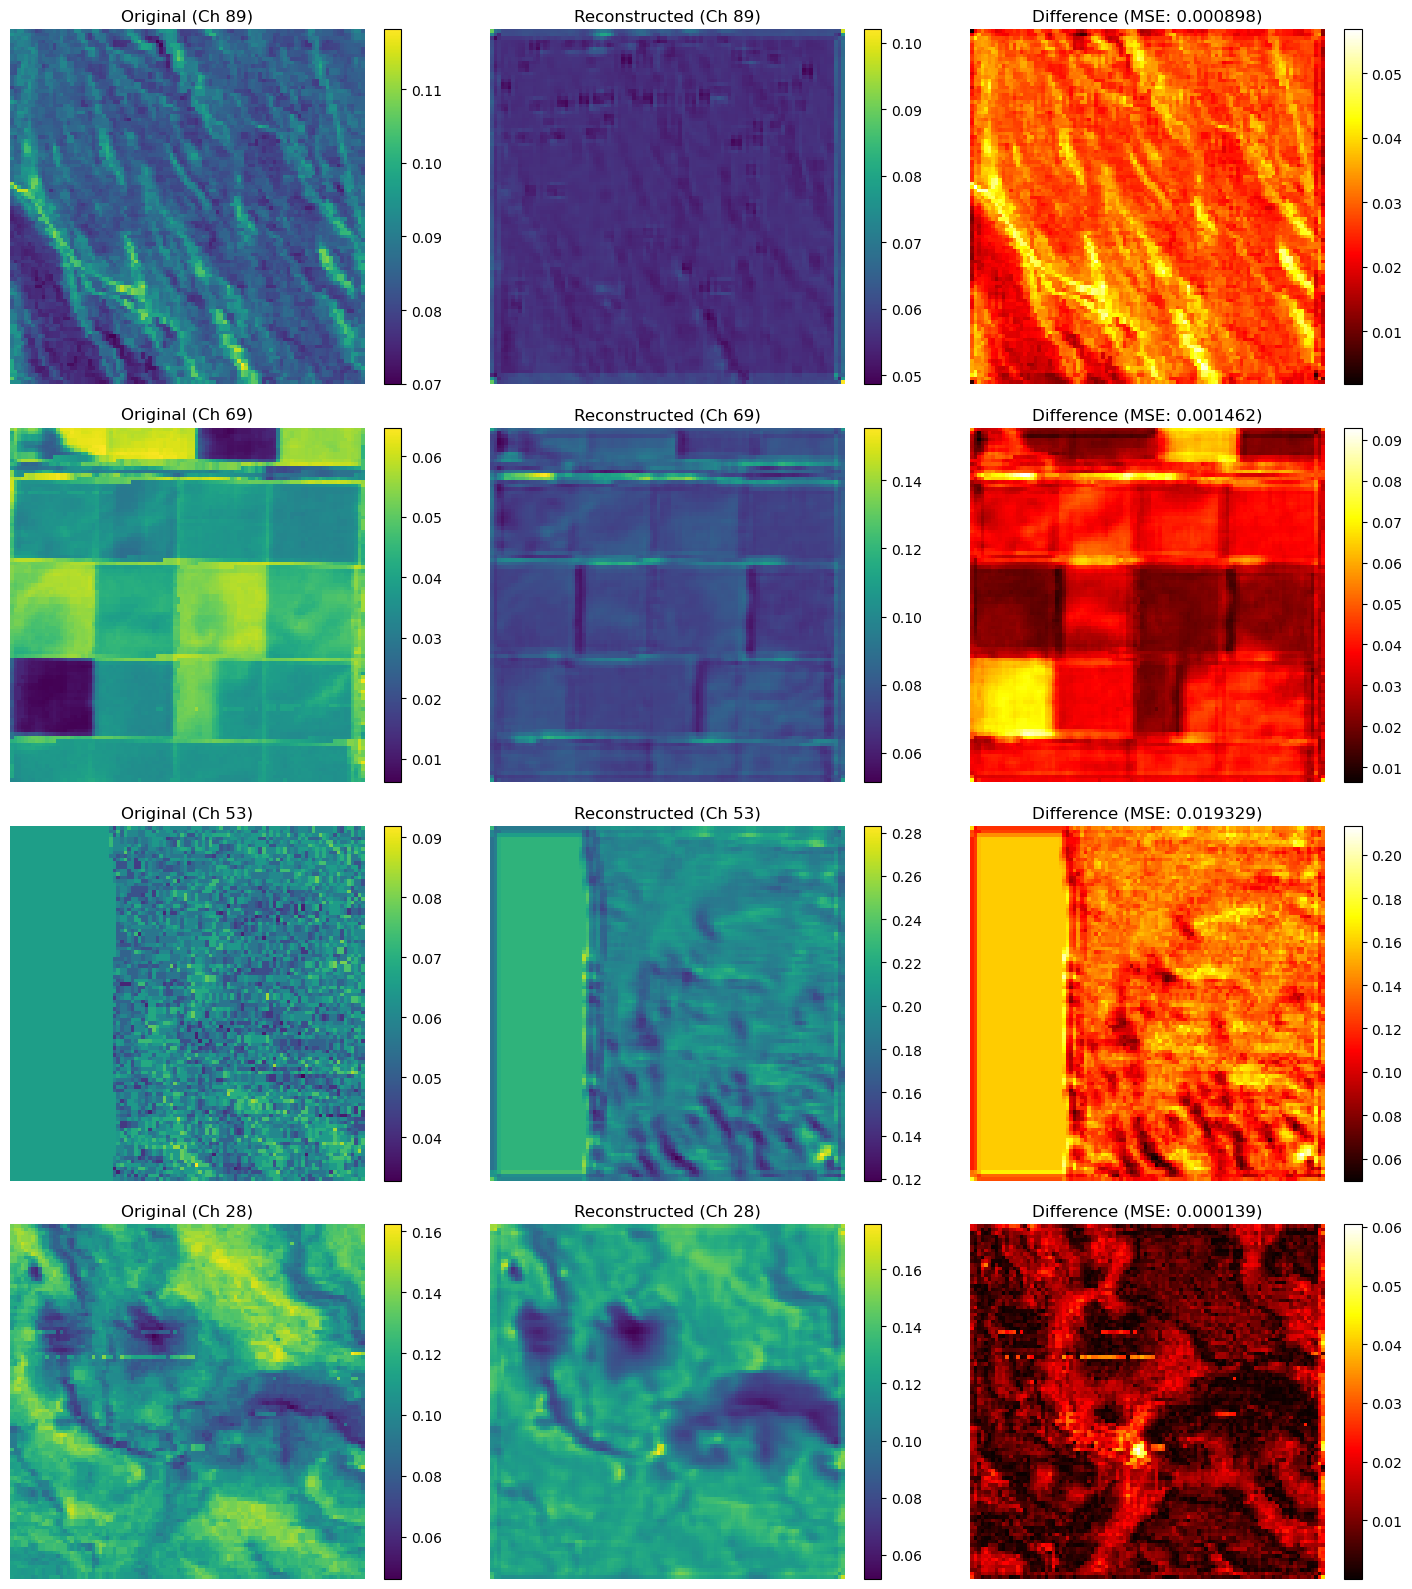

In [6]:
## Option 2: Run Stage 2 with a Specific Shape

# Pick one of the shapes from stage 1
shape_name = 'lowest_test_mse'  # Options: 'initial', 'lowest_condition_number', 'lowest_test_mse', 'final'
shape = recorded_shapes[shape_name]

# Train with this fixed shape
stage2_results = train_stage2(
    shape_name=shape_name,
    shape=shape,
    train_loader=train_loader,
    test_loader=test_loader,
    model_type=model_type,
    filter_scale_factor=filter_scale_factor,
    epochs=stage2_epochs,
    decoder_lr=decoder_lr,
    min_snr=min_snr,
    max_snr=max_snr,
    output_dir=os.path.join(output_dir, "stage2_only")
)

# Get results from stage 2
fixed_shape_model = stage2_results['model']

# Visualize reconstructions with the fixed shape model
visualize_reconstruction(fixed_shape_model, test_loader, device)

In [2]:
## Option 3: Run Both Stages at Once for All Shapes

# Run all stages at once
all_results = run_all_stages(
    tiles=tiles,
    latent_dim=latent_dim,
    model_type=model_type,
    use_fsf=use_fsf,
    shape2filter_path=shape2filter_path,
    filter2shape_path=filter2shape_path,
    filter_scale_factor=filter_scale_factor,
    stage1_epochs=stage1_epochs,
    stage2_epochs=stage2_epochs,
    batch_size=batch_size,
    encoder_lr=encoder_lr,
    decoder_lr=decoder_lr,
    min_snr=min_snr,
    max_snr=max_snr,
    add_random_baseline=True,  # Add a random shape for comparison
    output_dir=os.path.join(output_dir, "all_stages")
)

## Option 4: Skip Stage 1 and Load Existing Shapes

# Skip stage 1 and load shapes from a directory
load_shapes_dir = "results_fixed_shape_awan_20250402_052223/recorded_shapes/"

# Load recorded shapes
recorded_shapes, recorded_metrics = load_shapes_from_directory(load_shapes_dir)

# Check loaded shapes
for shape_name, shape in recorded_shapes.items():
    print(f"{shape_name} shape:")
    print(f"  - Condition Number: {recorded_metrics[shape_name]['condition_number']:.4f}")
    print(f"  - Test MSE: {recorded_metrics[shape_name]['test_mse']:.6f}")

# Create dataset for stage 2
dataset = AvirisDataset(tiles)
    
# Split into train and test sets
test_split = 0.2
test_size = int(len(dataset) * test_split)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Train with a loaded shape
shape_name = 'lowest_test_mse'
shape = recorded_shapes[shape_name]

stage2_results = train_stage2(
    shape_name=shape_name,
    shape=shape,
    train_loader=train_loader,
    test_loader=test_loader,
    model_type=model_type,
    filter_scale_factor=filter_scale_factor,
    epochs=stage2_epochs,
    decoder_lr=decoder_lr,
    min_snr=min_snr,
    max_snr=max_snr,
    output_dir=os.path.join(output_dir, "stage2_loaded")
)

## Analysis and Visualization

# Compare different shape results
if hasattr(all_results, 'stage2_results') and 'shapes' in all_results['stage2_results']:
    # Create comparison data
    stage2_comparison = {}
    
    for shape_name, results in all_results['stage2_results']['shapes'].items():
        stage2_comparison[shape_name] = {
            'train_losses': results['train_losses'],
            'test_losses': results['test_losses'],
            'condition_number': all_results['recorded_metrics'][shape_name]['condition_number'] 
                if shape_name in all_results['recorded_metrics'] else None
        }
    
    # Visualize comparison
    compare_stage2_results(
        stage2_comparison, 
        output_dir=os.path.join(output_dir, "shape_comparison")
    )

# Compare model performance metrics
if 'model' in stage2_results and 'model' in stage1_results:
    # Calculate model sizes
    stage1_model_size = calculate_model_size(stage1_results['model'])
    stage2_model_size = calculate_model_size(stage2_results['model'])
    
    print(f"Stage 1 model parameters: {stage1_model_size:,}")
    print(f"Stage 2 model parameters: {stage2_model_size:,}")
    
    # Measure inference time
    stage1_times = measure_inference_time(stage1_results['model'], test_loader, device)
    stage2_times = measure_inference_time(stage2_results['model'], test_loader, device)
    
    print(f"Stage 1 inference time: {stage1_times['avg_time_ms']:.2f} ms")
    print(f"Stage 2 inference time: {stage2_times['avg_time_ms']:.2f} ms")

print("Experiment completed successfully!")

NameError: name 'tiles' is not defined